In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

from sklearn.datasets import load_boston
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
from torch.utils.data import DataLoader

np.random.seed(42)

In [2]:
raw_data = load_boston()

data = raw_data.data 
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]

In [3]:
# Normalize 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)
print(X_train.shape)
print(X_test.shape)

torch.Size([354, 13])
torch.Size([152, 13])


In [4]:
class Generator(nn.Module): 
    def __init__(self, noise_dim, hidden_dim, input_dim):
        super().__init__()
        
        self.input = nn.Linear(noise_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.leaky_relu(self.input(z))
        out = F.leaky_relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        out = self.output(out)
        
        return out 

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out = F.leaky_relu(self.input(x))
        out = F.leaky_relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        out = self.output(out)
        
        return out

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM_GEN = 5
HIDDEN_DIM_DIS = 5
NOISE_DIM = 5
N_EPOCHS = 200
lr = 1e-4

In [6]:
gen = Generator(NOISE_DIM, HIDDEN_DIM_GEN, INPUT_DIM).type(torch.float64)
dis = Discriminator(INPUT_DIM, HIDDEN_DIM_DIS).type(torch.float64)

In [7]:
optimizer_D = torch.optim.Adam(list(dis.parameters()), lr=lr)
optimizer_G = torch.optim.Adam(list(gen.parameters()), lr=lr)

In [8]:
loo = LeaveOneOut()
print(loo.get_n_splits(X_train))
print(len(X_train))

logsigmoid = torch.nn.LogSigmoid()

354
354


In [9]:
train_acc = []
dis_acc = []
gen_acc = []

loss_dis = []
loss_gen = []

for i in range(N_EPOCHS):
    train_acc.append(0)
    loss_dis.append(0)
    loss_gen.append(0)
    dis_acc.append(0)
    gen_acc.append(0)
    num_batches = 0
    
    for train_index, valid_index in loo.split(X_train):
        x_train, x_valid = X_train[train_index], X_train[valid_index]
        """ Training discriminator """
        ## Zero grad 
        optimizer_D.zero_grad()
        
        ## Forward pass
        # Pass actual data 
        out_D_dis = dis(x_train)

        # Pass generated data 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_dis = gen(noise)
        out_DG_dis = dis(out_G_dis)

        ## Loss 
        loss_D = -torch.mean(logsigmoid(out_D_dis) + logsigmoid(1 - out_DG_dis))
        loss_dis[-1] += loss_D
        
        ## Backward 
        loss_D.backward()
        
        ## Update parameters
        optimizer_D.step()
        
        """ Train generator """
        ## Zero grad 
        optimizer_G.zero_grad()
        
        ## Forward pass 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_gen = gen(noise)
        out_DG_gen = dis(out_G_gen)
        
        ## Loss 
        loss_G = -torch.mean(logsigmoid(out_DG_gen))
        loss_gen[-1] += loss_G
        
        ## Backward
        loss_G.backward()
        
        ## Update parameters
        optimizer_G.step()
        
        """ Leave One Out Cross Validation """
        out_D_valid = dis(x_valid)
        out_D_valid = torch.nn.Sigmoid()(out_D_valid[0,0])
        out_D_valid_acc = int((out_D_valid > 0.5) == 1)
        
        dis_acc[-1] += out_D_valid_acc
        train_acc[-1] += out_D_valid_acc
        
        noise = torch.distributions.Uniform(0, 1).sample((x_valid.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_valid = gen(noise)
        out_DG_valid = dis(out_G_valid)
        out_DG_valid = torch.nn.Sigmoid()(out_DG_valid[0,0])
        out_DG_valid_acc = int((out_DG_valid > 0.5) == 0)
        
        gen_acc[-1] += out_DG_valid_acc
        train_acc[-1] += out_DG_valid_acc
        
        num_batches += 1
    
    loss_dis[-1] /= num_batches
    loss_gen[-1] /= num_batches
    
    dis_acc[-1] /= num_batches
    gen_acc[-1] /= num_batches
    
    train_acc[-1] /= num_batches * 2
    total_norm = 0
    
    print("Epoch [%d / %d] loss_dis: %f, loss_gen: %f, train acc: %f, dis_acc: %f, gen_acc: %f" % (i+1, N_EPOCHS, loss_dis[-1], loss_gen[-1], train_acc[-1], dis_acc[-1], gen_acc[-1]))

Epoch [1 / 200] loss_dis: 1.067694, loss_gen: 0.788157, train acc: 0.504237, dis_acc: 0.008475, gen_acc: 1.000000
Epoch [2 / 200] loss_dis: 1.016500, loss_gen: 0.752475, train acc: 0.596045, dis_acc: 0.192090, gen_acc: 1.000000
Epoch [3 / 200] loss_dis: 0.973734, loss_gen: 0.716041, train acc: 0.676554, dis_acc: 0.381356, gen_acc: 0.971751
Epoch [4 / 200] loss_dis: 0.928845, loss_gen: 0.697075, train acc: 0.573446, dis_acc: 0.474576, gen_acc: 0.672316
Epoch [5 / 200] loss_dis: 0.880472, loss_gen: 0.703709, train acc: 0.805085, dis_acc: 0.680791, gen_acc: 0.929379
Epoch [6 / 200] loss_dis: 0.836669, loss_gen: 0.704298, train acc: 0.913842, dis_acc: 0.951977, gen_acc: 0.875706
Epoch [7 / 200] loss_dis: 0.781803, loss_gen: 0.706620, train acc: 0.935028, dis_acc: 0.997175, gen_acc: 0.872881
Epoch [8 / 200] loss_dis: 0.748755, loss_gen: 0.701668, train acc: 0.851695, dis_acc: 0.994350, gen_acc: 0.709040
Epoch [9 / 200] loss_dis: 0.730138, loss_gen: 0.688875, train acc: 0.738701, dis_acc: 0.

Epoch [73 / 200] loss_dis: 0.862157, loss_gen: 0.518106, train acc: 0.500000, dis_acc: 1.000000, gen_acc: 0.000000
Epoch [74 / 200] loss_dis: 0.917541, loss_gen: 0.564991, train acc: 0.477401, dis_acc: 0.954802, gen_acc: 0.000000
Epoch [75 / 200] loss_dis: 1.020775, loss_gen: 0.473696, train acc: 0.471751, dis_acc: 0.943503, gen_acc: 0.000000
Epoch [76 / 200] loss_dis: 1.038745, loss_gen: 0.445871, train acc: 0.484463, dis_acc: 0.968927, gen_acc: 0.000000
Epoch [77 / 200] loss_dis: 1.015794, loss_gen: 0.463565, train acc: 0.495763, dis_acc: 0.991525, gen_acc: 0.000000
Epoch [78 / 200] loss_dis: 0.987872, loss_gen: 0.473650, train acc: 0.500000, dis_acc: 1.000000, gen_acc: 0.000000
Epoch [79 / 200] loss_dis: 0.965034, loss_gen: 0.475276, train acc: 0.500000, dis_acc: 1.000000, gen_acc: 0.000000
Epoch [80 / 200] loss_dis: 0.949263, loss_gen: 0.473964, train acc: 0.500000, dis_acc: 1.000000, gen_acc: 0.000000
Epoch [81 / 200] loss_dis: 0.938428, loss_gen: 0.475866, train acc: 0.500000, di

Epoch [144 / 200] loss_dis: 1.041612, loss_gen: 0.636109, train acc: 0.336158, dis_acc: 0.672316, gen_acc: 0.000000
Epoch [145 / 200] loss_dis: 1.034849, loss_gen: 0.589702, train acc: 0.382768, dis_acc: 0.765537, gen_acc: 0.000000
Epoch [146 / 200] loss_dis: 0.944603, loss_gen: 0.578899, train acc: 0.453390, dis_acc: 0.906780, gen_acc: 0.000000
Epoch [147 / 200] loss_dis: 0.889295, loss_gen: 0.613975, train acc: 0.471751, dis_acc: 0.943503, gen_acc: 0.000000
Epoch [148 / 200] loss_dis: 0.920914, loss_gen: 0.556851, train acc: 0.490113, dis_acc: 0.980226, gen_acc: 0.000000
Epoch [149 / 200] loss_dis: 0.945655, loss_gen: 0.503046, train acc: 0.497175, dis_acc: 0.994350, gen_acc: 0.000000
Epoch [150 / 200] loss_dis: 1.031253, loss_gen: 0.423610, train acc: 0.491525, dis_acc: 0.983051, gen_acc: 0.000000
Epoch [151 / 200] loss_dis: 0.965842, loss_gen: 0.533201, train acc: 0.444915, dis_acc: 0.889831, gen_acc: 0.000000
Epoch [152 / 200] loss_dis: 0.960683, loss_gen: 0.453667, train acc: 0.4

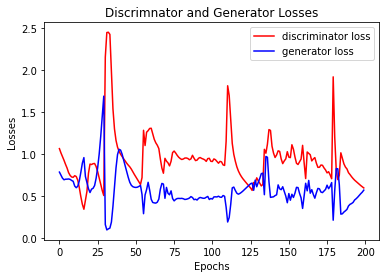

In [10]:
plt.plot(loss_dis, "r")
plt.plot(loss_gen, "b")
plt.legend(["discriminator loss", "generator loss"])
plt.title("Discrimnator and Generator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

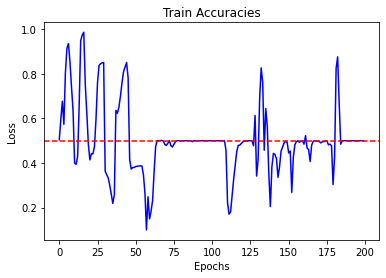

In [11]:
fig = plt.figure()
plt.plot(train_acc, color="b")
plt.axhline(0.5, linestyle='--', color="r")
plt.title("Train Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
pred = torch.nn.Sigmoid()(dis(X_train))
print(torch.mean(pred))

tensor(0.8410, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [13]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
pred = torch.nn.Sigmoid()(dis(gen(noise)))
print(torch.mean(pred))

tensor(0.5596, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [14]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
out_G_test = gen(noise)
out_G_test = out_G_test.detach().numpy()
corr_gen = np.corrcoef(out_G_test, rowvar=False)
print(corr_gen.shape)

(13, 13)


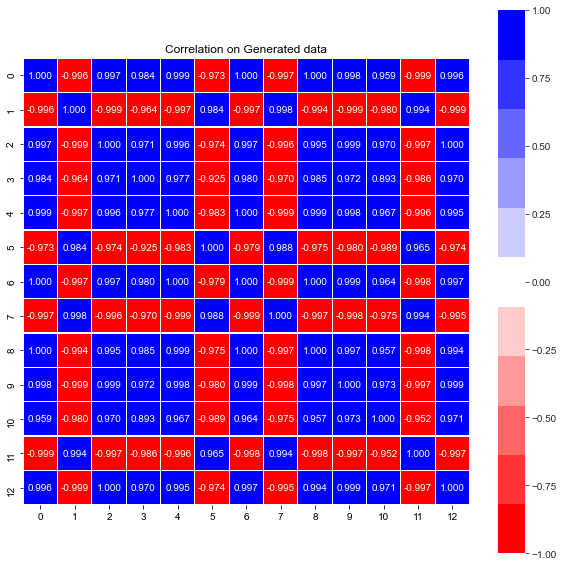

In [15]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1,
                                                 )

fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_gen, cmap=cmap, annot=True, fmt=".3f", vmin=1, vmax=-1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Generated data")
    plt.show()

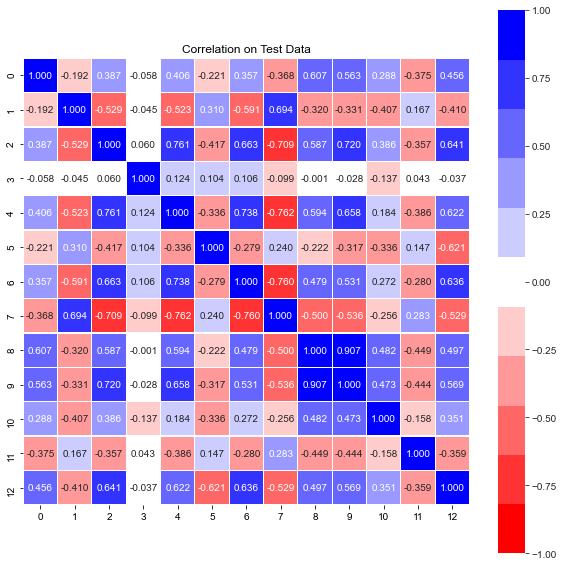

In [16]:
corr_test = np.corrcoef(X_train, rowvar=False)

fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=1, vmax=-1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [19]:
for i in range(100):
    # Generate data
    noise = torch.distributions.Uniform(0, 1).sample((100000, NOISE_DIM)).type(torch.float64)
    out_G_test = gen(noise)

    # Combine generated data and held out data 
    data = torch.cat((out_G_test, X_test))
    labels = torch.cat((torch.zeros(out_G_test.shape[0]), torch.ones(X_test.shape[0])))

    # Randomly mix the test data and generated data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = labels[indices].unsqueeze(1)

    out_D_test = dis(data)
    out_D_test = torch.nn.Sigmoid()(out_D_test)
    result = (out_D_test > 0.5).type(torch.float)
    
#     num_correct_one = labels[(result == labels) & (labels == 1)]
#     print(torch.sum(num_correct_one))
#     num_correct_zero = labels[(result == labels) & (labels == 0)]
#     print(torch.sum(num_correct_zero))
    acc = (result == labels).type(torch.float)
    mean_acc = torch.mean(acc)

    print("Test accuracy {}: {}".format(i + 1, mean_acc))

Test accuracy 1: 0.0015077083371579647
Test accuracy 2: 0.0015077083371579647
Test accuracy 3: 0.0015077083371579647
Test accuracy 4: 0.0015077083371579647
Test accuracy 5: 0.0015077083371579647
Test accuracy 6: 0.0015077083371579647
Test accuracy 7: 0.0015077083371579647
Test accuracy 8: 0.0015077083371579647
Test accuracy 9: 0.0015077083371579647
Test accuracy 10: 0.0015077083371579647
Test accuracy 11: 0.0015077083371579647
Test accuracy 12: 0.0015077083371579647
Test accuracy 13: 0.0015077083371579647
Test accuracy 14: 0.0015077083371579647
Test accuracy 15: 0.0015077083371579647
Test accuracy 16: 0.0015077083371579647
Test accuracy 17: 0.0015077083371579647
Test accuracy 18: 0.0015077083371579647
Test accuracy 19: 0.0015077083371579647
Test accuracy 20: 0.0015077083371579647
Test accuracy 21: 0.0015077083371579647
Test accuracy 22: 0.0015077083371579647
Test accuracy 23: 0.0015077083371579647
Test accuracy 24: 0.0015077083371579647
Test accuracy 25: 0.0015077083371579647
Test accu

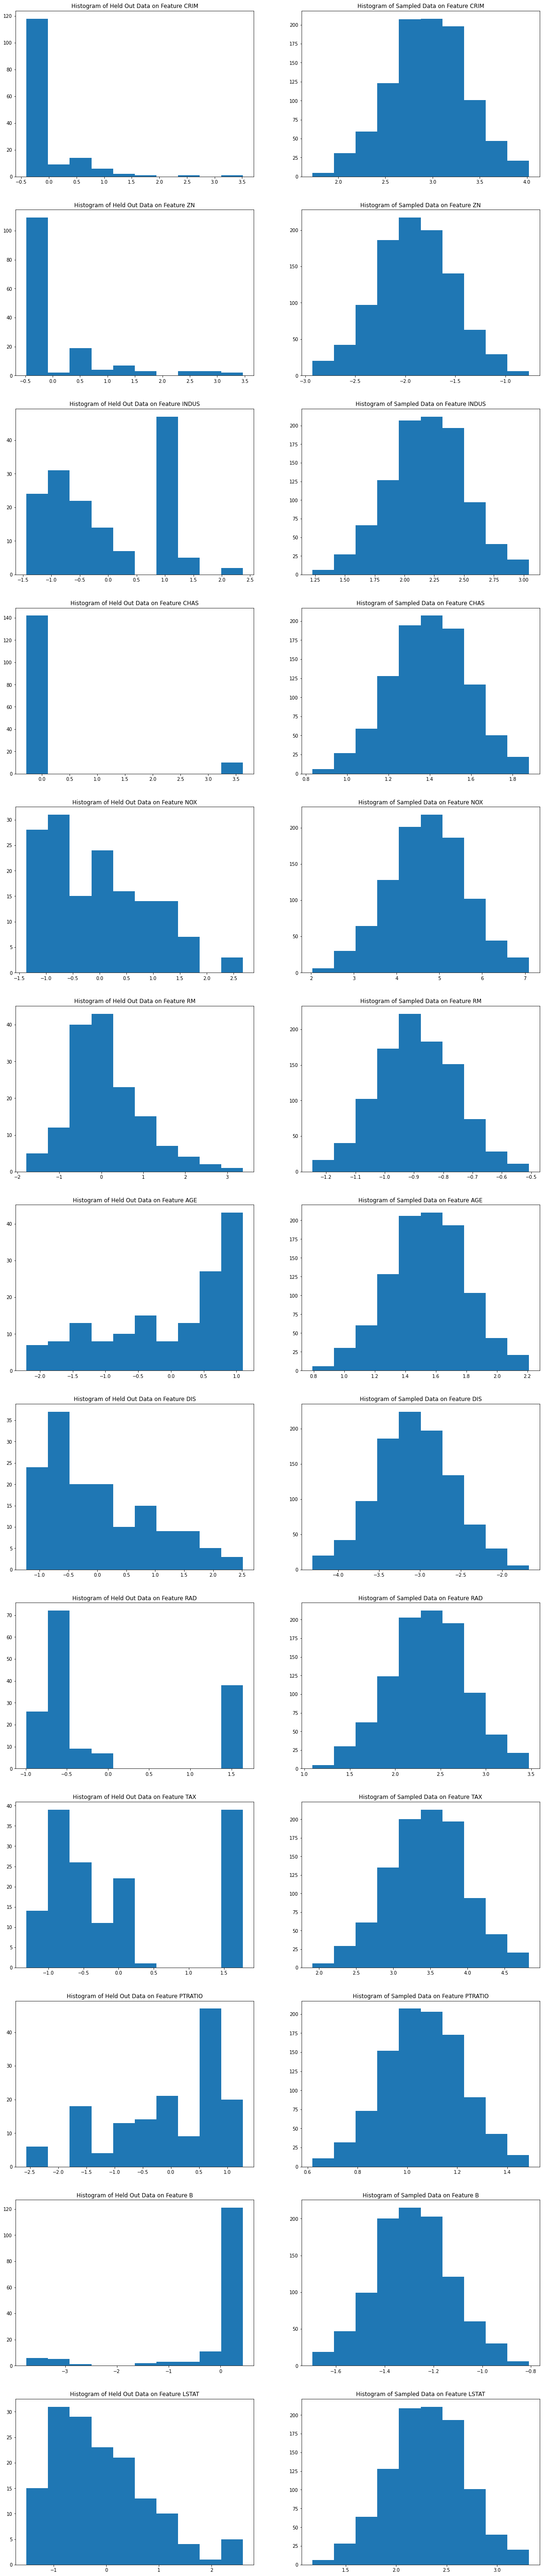

In [18]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
outG = gen(noise)

x_out = outG.detach().numpy()
x_test = X_test.numpy()

figs, axs = plt.subplots(x_out.shape[1], 2, figsize=(20, 100))

for i in range(x_out.shape[1]):
    x_test_mean = x_test[:,i].mean()
    axs[i, 0].hist(x_test[:,i])
    axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
    axs[i, 1].hist(x_out[:,i])
    axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

plt.show()